In [2]:
!pip install "u8darts[all]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import RNNModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os

from lib.constants import *
import lib.preprocessing.wavelets as wavelets
import lib.preprocessing.df_utils as df_utils
import lib.visualization.plot as plot
from lib.preprocessing.normalization import Normalizer, Scalers

mpl.rcParams.update(mpl.rcParamsDefault)

In [4]:
prices_daily = pd.read_parquet('lib/data/apple_daily.parquet')
prices_daily = df_utils.localize_dataframe_index(prices_daily)
prices_daily.head()

,close,high,low,open,volume,divCash
date,,,,,,
2010-01-04,6.431808,6.446534,6.382820,6.414376,493730093,0.0
2010-01-05,6.442927,6.479292,6.408967,6.449539,601905401,0.0
2010-01-06,6.340444,6.468473,6.333832,6.442927,552160552,0.0
2010-01-07,6.328723,6.371399,6.282741,6.363886,477131677,0.0
2010-01-08,6.370798,6.371399,6.283041,6.320308,447611247,0.0


In [5]:
ts_daily = df_utils.get_df_with_columns(prices_daily, ['close'])
ts_daily.head()

,close
date,
2010-01-04,6.431808
2010-01-05,6.442927
2010-01-06,6.340444
2010-01-07,6.328723
2010-01-08,6.370798


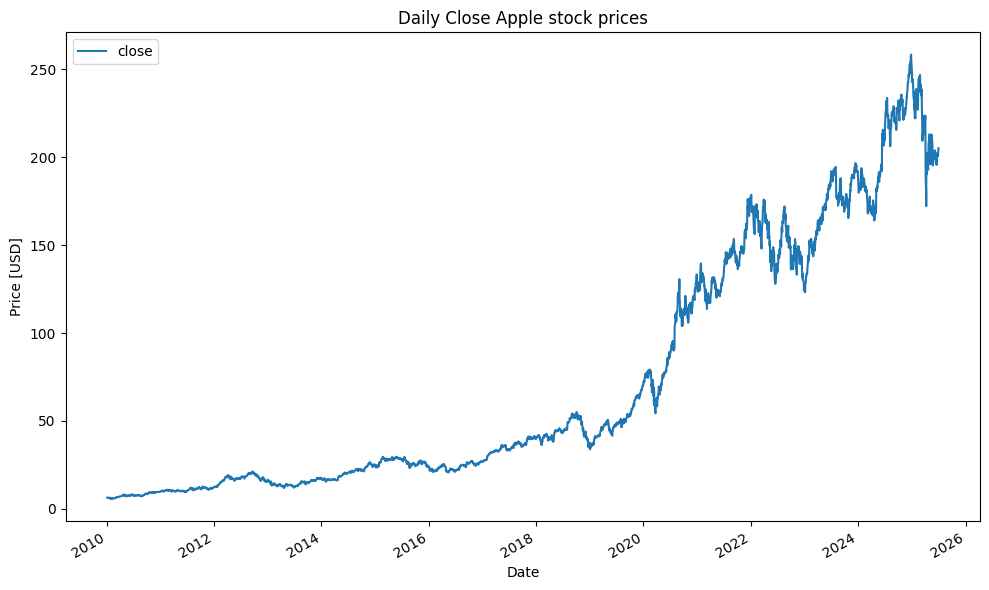

In [6]:
plot.plot_dataframe(ts_daily, title='Daily Close Apple stock prices', ylabel='Price [USD]', xlabel='Date')

In [7]:
ts_daily = ts_daily.asfreq('B', method='pad')
ts_daily

,close
date,
2010-01-04,6.431808
2010-01-05,6.442927
2010-01-06,6.340444
2010-01-07,6.328723
2010-01-08,6.370798
...,...
2025-06-24,200.300000
2025-06-25,201.560000
2025-06-26,201.000000


In [8]:
ts_daily['denoised'] = wavelets.wavelet_denoise_series(ts_daily["close"], wavelet='coif3', level=1)
ts_daily['noise'] = ts_daily["close"] - ts_daily['denoised']

Signal-to-Noise Ratio (SNR): 42.84 dB


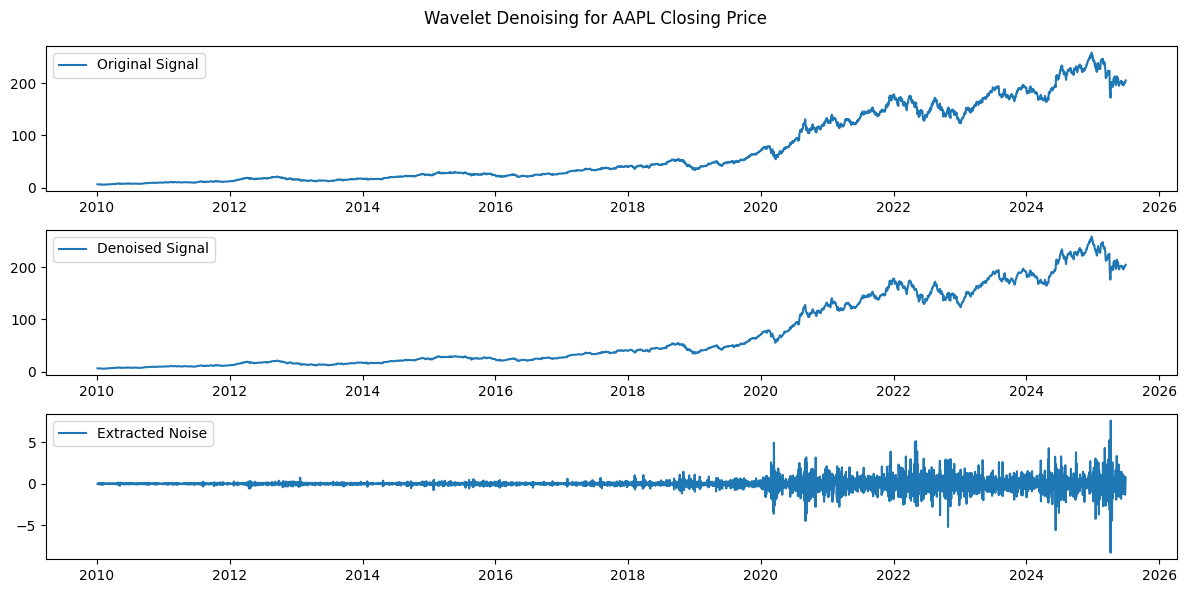

In [9]:
wavelets.plot_wavelet_denoising(ts_daily, f"{TICKER_APPLE} Closing Price")

In [10]:
series = TimeSeries.from_dataframe(ts_daily, value_cols=["denoised"])
series.plot(label='Time series close price')

<Axes: xlabel='date'>

In [11]:
normalizer = Normalizer(diff=False)
normalized_series = normalizer.log_normalize(series)
# normalized_series = series
normalized_series.plot(label='Normalized time series close price')

<Axes: xlabel='date'>

In [12]:
test_size = 160
val_size = 500
train_size = len(normalized_series) - val_size - test_size

train, val, test = (
    normalized_series[:train_size],
    normalized_series[train_size:train_size + val_size],
    normalized_series[-test_size:],
)

print(f"Train size: {len(train)}, Val size: {len(val)}, Test size: {len(test)}")

scaler = Scalers()
train_scaled = scaler.fit_scaler(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

Train size: 3381, Val size: 500, Test size: 160


In [ ]:
from darts.metrics import mse

parameters = {
    'input_chunk_length':[120],
    'training_length':[121],
    'model':['LSTM'],
    'n_epochs':[100, 400],#, 300],
    'hidden_dim':[64, 128],#, 100, 250],
    'n_rnn_layers':[2, 3],
    'dropout':[0.1, 0.2, 0.25],
    'batch_size':[16, 32, 64],
    'optimizer_kwargs':[{"lr": 1e-3}, {"lr": 1e-4}],
    'pl_trainer_kwargs':[{
        "accelerator": "gpu",
        "devices": 1,
        # "callbacks": [early_stopper]
    }],
    "add_encoders": [{
        # a) atrybuty daty (one-hot kiedy ma sens)
        "datetime_attribute": {
            "past": ["dayofweek"],      # pon..niedz. (one-hot)
            "future": ["dayofweek"],    # pon..niedz. (one-hot)
        },
        # b) cykliczne enkodowanie (sin/cos) — tu np. dzień roku
        "cyclic": {
            "past": ["dayofyear"],      # -> automatycznie zrobi sin/cos
            "future": ["dayofyear"],    # -> automatycznie zrobi sin/cos
        },
        # możesz dodać też np. 'month' itd.
    }]
}

output = RNNModel.gridsearch(
    parameters=parameters,
    series= train_scaled,
    val_series=val_scaled,
    metric=mse,
    reduction=np.mean,
    last_points_only=False,
    verbose=True,
    n_jobs=-1,
)

gridsearch: 100%|██████████| 144/144 [5:43:53<00:00, 143.29s/it]


In [1]:
output

NameError: name 'output' is not defined

(RNNModel(model=LSTM, hidden_dim=64, n_rnn_layers=3, dropout=0.1, training_length=101, input_chunk_length=100, n_epochs=50, batch_size=64, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1}, add_encoders={'datetime_attribute': {'past': ['dayofweek'], 'future': ['dayofweek']}, 'cyclic': {'past': ['dayofyear'], 'future': ['dayofyear']}}),
 {'input_chunk_length': 100,
  'training_length': 101,
  'model': 'LSTM',
  'n_epochs': 50,
  'hidden_dim': 64,
  'n_rnn_layers': 3,
  'dropout': 0.1,
  'batch_size': 64,
  'optimizer_kwargs': {'lr': 0.001},
  'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': 1},
  'add_encoders': {'datetime_attribute': {'past': ['dayofweek'],
    'future': ['dayofweek']},
   'cyclic': {'past': ['dayofyear'], 'future': ['dayofyear']}}},
 0.12203777799073133)

In [24]:
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=100,
    min_delta=1e-5,
    mode="min",
)

model_lstm = RNNModel(
    model="LSTM",
    input_chunk_length=120,
    training_length=121,
    hidden_dim=150,
    n_rnn_layers=3,
    batch_size=32,
    n_epochs=2000,
    dropout=0.1,
    optimizer_kwargs={"lr": 1e-4},
    random_state=42,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": 1,
        "callbacks": [early_stopper]
    },
    add_encoders={
        # a) atrybuty daty (one-hot kiedy ma sens)
        "datetime_attribute": {
            "past": ["dayofweek"],      # pon..niedz. (one-hot)
        },
        # b) cykliczne enkodowanie (sin/cos) — tu np. dzień roku
        "cyclic": {
            "past": ["dayofyear"],      # -> automatycznie zrobi sin/cos
        },
        # możesz dodać też np. 'month' itd.
    }
)

In [ ]:
model_lstm.fit(
    train_scaled,
    val_series=val_scaled,
    verbose=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 454 K  | train
6 | V               | Linear           | 151    | train
-------------------------------------------------------------
454 K     Trainable params
0         Non-trainable p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [16]:
lstm_forecast = model_lstm.historical_forecasts(
    test_scaled,
    forecast_horizon=1,
    retrain=False,
    last_points_only=True,
    verbose=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [17]:
lstm_forecast_unscaled = scaler.inverse_scaler(lstm_forecast)
lstm_forecast_inversed = normalizer.inverse_log_normalize(
        lstm_forecast_unscaled
    )

In [18]:
f = lstm_forecast_inversed.to_dataframe()
f.columns = ["close"]

In [19]:
t = ts_daily[["denoised"]][-60:]

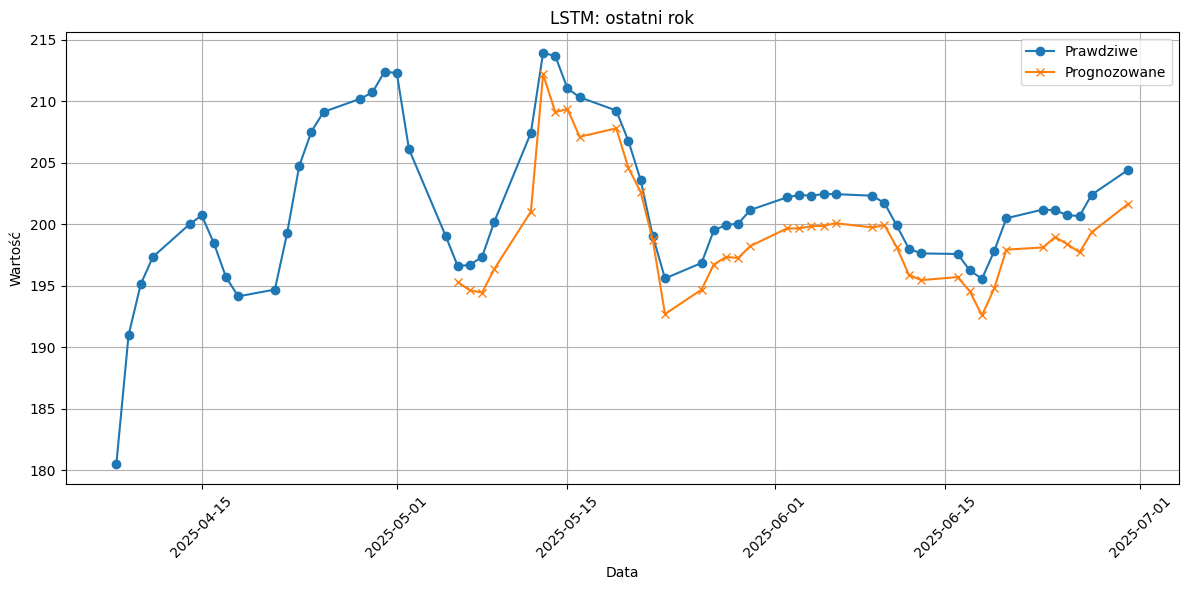

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(t["denoised"], label="Prawdziwe", marker='o')
plt.plot(f["close"], label="Prognozowane", marker='x')
plt.title("LSTM: ostatni rok")
plt.xlabel("Data")
plt.ylabel("Wartość")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
model_lstm.save("lstm_model.pth.tar")